# 1. Import necessary modules

In [27]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import joblib

# 2. Loading the Data:

In [28]:
# # ZIP files
# train_zip = 'GUIDE_Train.csv.zip'
# test_zip = 'GUIDE_Test.csv.zip'

# # Unziping the training file
# with zipfile.ZipFile(train_zip, 'r') as zip_ref:
#     zip_ref.extractall()

# # Unziping the testing file
# with zipfile.ZipFile(test_zip, 'r') as zip_ref:
#     zip_ref.extractall()

In [29]:
# # Now reading the unzipped CSV files
# train_data = pd.read_csv('GUIDE_Train.csv')
# test_data = pd.read_csv('GUIDE_Test.csv')

# 3. Understanding the Data:
## Dataset Overview:
* GUIDE_Train.csv with 9.5M rows and 45 columns.
* GUIDE_Test.csv with 4.1M rows and 46 columns.

# Train Data

In [30]:
def optimize_memory(df):
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')
    return df

In [31]:
chunks = []
train_dataset = "C:\cybersecurity_pday4\mycyber\GUIDE_Train.csv\GUIDE_Train.csv"
# Reading the dataset in chunks and process each chunk
for chunk in pd.read_csv(train_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
train_data = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks

In [32]:
train_data.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [33]:
print(train_data.shape)

(9516837, 45)


In [34]:
train_data.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City'],
      dtype='object')

In [35]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Id                  int64   
 1   OrgId               int16   
 2   IncidentId          int32   
 3   AlertId             int32   
 4   Timestamp           object  
 5   DetectorId          int16   
 6   AlertTitle          int32   
 7   Category            object  
 8   MitreTechniques     object  
 9   IncidentGrade       category
 10  ActionGrouped       object  
 11  ActionGranular      object  
 12  EntityType          object  
 13  EvidenceRole        category
 14  DeviceId            int32   
 15  Sha256              int32   
 16  IpAddress           int32   
 17  Url                 int32   
 18  AccountSid          int32   
 19  AccountUpn          int32   
 20  AccountObjectId     int32   
 21  AccountName         int32   
 22  DeviceName          int32   
 23  NetworkMessageId    int32   
 24

In [36]:
train_data.describe()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
count,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,...,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06
mean,8.425494e+11,1.815800e+02,7.066349e+04,4.065188e+05,1.106724e+02,2.947315e+03,9.566476e+04,1.287191e+05,2.857506e+05,1.503317e+05,...,3.342790e+03,8.807955e+02,2.622621e+05,1.076172e+05,3.583477e+03,4.898537e+00,6.465558e+01,2.236742e+02,1.351488e+03,9.936183e+03
std,4.962499e+11,3.867784e+02,1.208369e+05,4.592827e+05,4.351038e+02,1.146150e+04,1.635288e+04,3.399208e+04,1.412240e+05,3.750795e+04,...,5.103381e+02,1.291083e+01,8.152956e+04,3.220835e+04,9.020262e+01,7.035099e-01,9.314929e+00,6.279729e+01,3.509808e+02,2.606812e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.123169e+11,1.000000e+01,5.040000e+02,2.324200e+04,2.000000e+00,2.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
50%,8.418136e+11,4.500000e+01,1.033600e+04,2.166520e+05,9.000000e+00,1.100000e+01,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
75%,1.271310e+12,1.710000e+02,8.432900e+04,6.715770e+05,4.500000e+01,1.800000e+02,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
max,1.709397e+12,6.147000e+03,5.997060e+05,1.721456e+06,9.522000e+03,1.131740e+05,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04


## Handling Missing Data

In [37]:
train_data.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       5468386
IncidentGrade           51340
ActionGrouped         9460773
ActionGranular        9460773
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        9420025
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          9441956
FileName                    0
FolderPath

In [38]:
# Droping Columns with More Than 50% Missing Values:
missing_percentage = train_data.isnull().mean() * 100
columns_to_drop = missing_percentage[missing_percentage > 50].index
train_data.drop(columns=columns_to_drop, axis=1, inplace=True)
print(f"Columns dropped due to >50% missing values: {columns_to_drop.tolist()}")

Columns dropped due to >50% missing values: ['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']


#### 'IncidentGrade', Since this is our target column, we cannot have missing values here.
#### The best option is to drop rows where the IncidentGrade is missing, as imputing the target variable might lead to misleading results.

In [39]:
# Droping rows where 'IncidentGrade' is missing
train_data = train_data.dropna(subset=['IncidentGrade'])

In [40]:
train_data.isnull().sum()

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
Timestamp             0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
dtype: int64

In [41]:
train_data.duplicated().sum()

np.int64(542692)

In [42]:
# Droping duplicate rows from the dataset
train_data = train_data.drop_duplicates()

print(f"Number of rows after removing duplicates: {train_data.shape[0]}")

Number of rows after removing duplicates: 8922805


In [43]:
# Target variable distribution
print("Target variable distribution:")
train_data['IncidentGrade'].value_counts()

Target variable distribution:


IncidentGrade
BenignPositive    3827800
TruePositive      3140126
FalsePositive     1954879
Name: count, dtype: int64

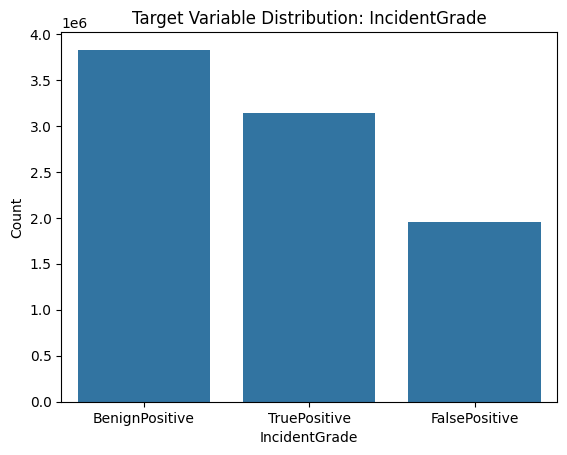

In [44]:
sns.countplot(data=train_data, x='IncidentGrade', order=train_data['IncidentGrade'].value_counts().index)
plt.title('Target Variable Distribution: IncidentGrade')
plt.xlabel('IncidentGrade')
plt.ylabel('Count')
plt.show()

## Feature Exploration and Engineering

In [45]:
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'])
train_data['Year'] = train_data['Timestamp'].dt.year
train_data['Month'] = train_data['Timestamp'].dt.month
train_data['Day'] = train_data['Timestamp'].dt.day
train_data['Hour'] = train_data['Timestamp'].dt.hour

train_data.drop(columns='Timestamp',inplace=True)

In [ ]:
train_data.columns